In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from mec import make_circle

In [2]:
GF = galois.GF(2)
def find_distance(H):
    # good thing these codes are small
    n = H.shape[1]
    min_weight = n
    for i in range(2**n):
        cw = bin(i)[2:].zfill(n)
        cw = [int(digit) for digit in cw]
        if not np.any((H @ cw) % 2):
            weight = np.count_nonzero(cw)
            if 0 < weight < min_weight:
                min_weight = weight
    return min_weight

def repetition_code(n):
    H = np.zeros((n-1,n))
    for i in range(n-1):
        H[i][i] = H[i][i+1] = 1
    return H

def concatenate(H, rep_size):
    # rep = repetition_code(rep_size)
    n = H.shape[1]*rep_size
    k = H.shape[1]-np.linalg.matrix_rank(H)
    new_H = np.zeros((n-k,n), dtype=np.uint8)

    new_H[0:H.shape[0], 0:H.shape[1]] = H
    for i in range(H.shape[1]):
        for j in range(rep_size-1):
            new_H[H.shape[0]+(i*(rep_size-1)+j)][i+(j*H.shape[1])] = 1
            new_H[H.shape[0]+(i*(rep_size-1)+j)][i+((j+1)*H.shape[1])] = 1

    return new_H

C:\Users\nfber\AppData\Roaming\Python\Python38\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
def find_best_1D_embedding(H, minimize_checks=False):
    # find best ordering of bit and checks to reduce lr edges
    # good thing the codes are small
    n = H.shape[1]
    m = H.shape[0]
    bits = np.zeros(n)
    checks = np.zeros(m)

    check_nbhd = []
    for check in range(m):
        check_nbhd.append(np.where(H[check])[0])

    best_per = None
    min_val = np.count_nonzero(H)
    best_lr_checks = None

    for per in itertools.permutations([f"b{i}" for i in range(n)] + [f"c{i}" for i in range(m)]):
        # probably no checks at the end (at least if all checks have at least two bits in them)
        # also add condition for two checks next to each other, shouldn't really happen probably
        if per <= per[::-1]:
            if (per[0][0] == "c") or (per[-1][0] == "c"): continue
            fail = 0
            for i in range(n+m-1):
                if (per[i][0] == per[(i+1)%(n+m)][0] == "c"):
                    fail = 1
                    break
            if fail: continue

            for i, node in enumerate(per):
                if node[0] == "b":
                    bits[int(node[1:])] = i
                else:
                    checks[int(node[1:])] = i
            
            num_lr = 0
            lr_checks = set()

            for check in range(m):
                for bit in check_nbhd[check]:
                    if abs(checks[check]-bits[bit]) != 1:
                        num_lr += 1
                        lr_checks |= {(check, bit)}
                        if minimize_checks:
                            break

            if num_lr < min_val:
                best_per = per
                min_val = num_lr
                best_lr_checks = lr_checks 

    return best_per, min_val, best_lr_checks

In [4]:
def search_codes(n, k, d, num_iters):
    # singleton bound d <= n - k + 1
    if d > n-k+1:
        raise ValueError("Singleton bound is violated.")

    best_code = None
    best_weight = n*(n-k)

    for i in range(num_iters):
        H = np.random.randint(2, size=(n-k,n))
        rank = np.linalg.matrix_rank(GF(H))
        if (rank != n-k): continue

        distance = find_distance(H)
        if distance == d:
            if (np.count_nonzero(H) < best_weight):
                best_code = H
                best_distance = distance
    
    return best_code

def search_almost_local(n, k, num_iters):
    best_code = None
    best_d = 0
    
    for i in range(num_iters):
        H = np.zeros((n-k,n), dtype=np.uint8)
        for j in range(n-k):
            tmp = np.array([0] * 2 + [1] * (n-2))
            np.random.shuffle(tmp)
            H[j] = tmp


        rank = np.linalg.matrix_rank(GF(H))
        if (rank != n-k): continue

        d = find_distance(H)
        if d > best_d:
            best_code = H
            best_d = d
    
    return best_code



def search_codes_dvdc(n, dv, dc):
    # dv, w_c. Every bit is in this many checks
    # dc, w_r. Every check has this many bits in it
    m = (n*dv)//dc
    k = n - m

    vs = np.array([[j for i in range(dv)] for j in range(n)]).flatten()
    cs = np.array([[j for i in range(dc)] for j in range(m)]).flatten()

    H = np.zeros((m, n), dtype=np.uint8)

    while (vs.size and cs.size):
        # choose random 'stub' from each array
        double_edge = True
        while(double_edge):
            v_ind = np.random.randint(0, len(vs))
            c_ind = np.random.randint(0, len(cs))

            if (H[cs[c_ind]][vs[v_ind]] != 1):
                double_edge = False
                H[cs[c_ind]][vs[v_ind]] = 1
                vs = np.delete(vs, v_ind)
                cs =np.delete(cs, c_ind)
        
    print(f"[[{n},{np.linalg.matrix_rank(GF(H))},{find_distance(H)}]]")

In [6]:
oH = np.array([[1,1,1]])
# oH = search_codes(6,2,4,1000)

# oH = np.array([ # [5,2,3]
#     [1,0,0,1,0],
#     [0,1,1,0,0],
#     [0,1,0,1,1]
# ])

# oH = np.array([ # [6,2,4]
#     [1,0,1,0,0,0],
#     [0,1,0,1,0,0],
#     [1,1,0,0,1,0],
#     [0,0,0,0,1,1]
# ])

n = oH.shape[1]
m = np.linalg.matrix_rank(GF(oH))
d = find_distance(oH)
H = concatenate(oH, 2)
print(f"[{n},{n-m},{d}]")

[3,2,2]


In [7]:
for i in range(2,10):
    k = (n-m)
    print(f"[[{(n*i)**2+(n*i-2)**2},{k**2},{i*d}]],[[{((d*i)**2+(d*i-1)**2)*(k**2)},{k**2},{d*i}]]")

[[52,4,4]],[[100,4,4]]
[[130,4,6]],[[244,4,6]]
[[244,4,8]],[[452,4,8]]
[[394,4,10]],[[724,4,10]]
[[580,4,12]],[[1060,4,12]]
[[802,4,14]],[[1460,4,14]]
[[1060,4,16]],[[1924,4,16]]
[[1354,4,18]],[[2452,4,18]]


In [8]:
best_emb = find_best_1D_embedding(oH, False)
print(best_emb)

(('b0', 'b1', 'c0', 'b2'), 1, {(0, 0)})


In [9]:
tot_gens = 2 * (H.shape[0] * H.shape[1])
tot_edges = 2 * np.count_nonzero(H) * (H.shape[0]+H.shape[1])
lr_edges = 2 * np.count_nonzero(H[:oH.shape[0]]) * (H.shape[0]+H.shape[1])
lr_edges_emb = 2 * best_emb[1]  * (H.shape[0]+H.shape[1])
lr_gens = 2 * len(best_emb[2]) * (H.shape[0]+H.shape[1])

print(f"total edges: {tot_edges}")
print(f"lr edges: {lr_edges}, {np.round(lr_edges/tot_edges, 3)}")
print(f"lr edges: {lr_edges_emb}, {np.round(lr_edges_emb/tot_edges, 3)}")
print(f"total gens: {tot_gens}")

total edges: 180
lr edges: 60, 0.333
lr edges: 20, 0.111
total gens: 48


In [10]:
def embed_1D(oH, rep_size, best_emb=None):
    H = concatenate(oH, rep_size)
    if best_emb == None: best_emb = find_best_1D_embedding(oH)
    lr_connections = best_emb[2]

    checks = np.zeros(H.shape[0], dtype=int)
    bits = np.zeros(H.shape[1], dtype=int)

    emb = np.empty(oH.shape[0]+oH.shape[1], dtype=object)
    for i in range(oH.shape[0]+oH.shape[1]):
        if best_emb[0][i][0] == "b":
            emb[i] = np.empty(2*rep_size-1, dtype=object)
            bits[int(best_emb[0][i][1:])] = i
        else:
            emb[i] = best_emb[0][i]

    for bit in range(oH.shape[1]):
        # place the repetition codes
        for i in range(2*rep_size-1):
            if (i % 2 == 0):
                emb[bits[bit]][i] = f"b{bit+((i//2)*oH.shape[1])}"
            else:
                emb[bits[bit]][i] = f"c{oH.shape[0]+((i-1)//2)+(bit*(rep_size-1))}"

    for i, node in enumerate(np.hstack(emb)):
        if node[0] == "b":
            bits[int(node[1:])] = i
        else:
            checks[int(node[1:])] = i

    emb = np.hstack(emb)
    # print(emb)
    # print(bits)
    # print(checks)
    # print()

    new_lr_connections = []
    for check in range(oH.shape[0]):
        # only need to weight balance the original checks
        print(f"c{check}: {np.where(oH[check])[0]}")

        for bit in np.where(oH[check])[0]:
            min_dist = len(emb)
            new_bit = bit
            for i in range(rep_size):
                tmp_dist = abs(checks[check] - bits[bit+(i*oH.shape[1])])
                if tmp_dist < min_dist:
                    min_dist = tmp_dist
                    new_bit = bit + (i*oH.shape[1])

            print(f"{bit}-->{new_bit}")
            if (check, bit) in lr_connections: new_lr_connections.append((check, new_bit))
            H[check][bit] = 0
            H[check][new_bit] = 1

    # print(H)
    return H, emb, new_lr_connections

rep_size = 2
print(f"[{rep_size*n},{n-m},{rep_size*d}]")
H, emb, lr_cons = embed_1D(oH, rep_size, best_emb=best_emb)
print(emb)
print(H)
print(lr_cons)

[6,2,4]
c0: [0 1 2]
0-->3
1-->4
2-->2
['b0' 'c1' 'b3' 'b1' 'c2' 'b4' 'c0' 'b2' 'c3' 'b5']
[[0 0 1 1 1 0]
 [1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]
[(0, 3)]


In [11]:
def get_relative_positions(H, emb):
    n = H.shape[1]
    m = H.shape[0]

    bits = np.zeros(n, dtype=int)
    checks = np.zeros(m, dtype=int)

    bit_nbhd = []
    for bit in range(n):
        bit_nbhd.append(np.where(H[:,bit])[0])
    check_nbhd = []
    for check in range(m):
        check_nbhd.append(np.where(H[check])[0])

    for i, node in enumerate(emb):
        if node[0] == "b":
            bits[int(node[1:])] = i
        else:
            checks[int(node[1:])] = i

    rel_positions = np.empty(n+m, dtype=object)

    for i, bit in enumerate(bits):
        rel_positions[bit] = [checks[check] - bit for check in bit_nbhd[i]]
    for i, check in enumerate(checks):
        rel_positions[check] = [bits[bit] - check for bit in check_nbhd[i]]

    return rel_positions

In [13]:
def embed_hgp(H, emb):
    lattice = np.empty((len(emb), len(emb)), dtype=object)
    rel_pos = get_relative_positions(H, emb)

    n = H.shape[1]
    k = n-np.linalg.matrix_rank(GF(H))
    qbts = np.array([None for _ in range(n**2+(n-k)**2)])

    qb_ct = 0
    x_ct = 0
    z_ct = 0
    for i in range(len(emb)):
        for j in range(len(emb)):
            if emb[i][0] == emb[j][0]:
                lattice[i][j] = f"q{qb_ct}"
                qbts[qb_ct] = (i,j)
                qb_ct += 1
            elif emb[i][0] == "c" and emb[j][0] == "b":
                lattice[i][j] = f"x{x_ct}"
                x_ct += 1
            else:
                lattice[i][j] = f"z{z_ct}"
                z_ct += 1
    
    # print(lattice)
    Hz = np.zeros((z_ct, qb_ct), dtype=np.uint8)
    Hx = np.zeros((x_ct, qb_ct), dtype=np.uint8)

    for i, qbt in enumerate(qbts):
        y, x = qbt
        hor_nbrs = rel_pos[x]
        ver_nbrs = rel_pos[y]

        for nbr in hor_nbrs:
            gen = lattice[y][x+nbr]
            gen_type = gen[0]
            gen_ind = int(gen[1:])
            if gen_type == "z":
                Hz[gen_ind][i] = 1
            else:
                Hx[gen_ind][i] = 1
        for nbr in ver_nbrs:
            gen = lattice[y+nbr][x]
            gen_type = gen[0]
            gen_ind = int(gen[1:])
            if gen_type == "z":
                Hz[gen_ind][i] = 1
            else:
                Hx[gen_ind][i] = 1

    return Hz, Hx, qbts
Hz, Hx, qbts = embed_hgp(H, emb)

n = Hx.shape[1]
k = Hx.shape[1]-2*Hx.shape[0]
print(f"[[{n},{k},{rep_size*d}]]")

[[52,4,4]]


(array([0.625     , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.        , 0.04166667]),
 array([1.        , 1.10081452, 1.20162905, 1.30244357, 1.40325809,
        1.50407262, 1.60488714, 1.70570166, 1.80651619, 1.90733071,
        2.00814524, 2.10895976, 2.20977428, 2.31058881, 2.41140333,
        2.51221785, 2.61303238, 2.7138469 , 2.81466142, 2.91547595]),
 <BarContainer object of 19 artists>)

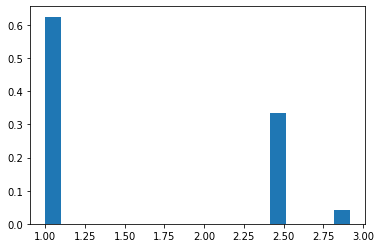

In [14]:
x_mask = np.zeros(Hx.shape[0], dtype=np.uint8)
z_mask = np.zeros(Hz.shape[0], dtype=np.uint8)

rs = []
for i in range(Hx.shape[0]):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
    if make_circle(gen_qbts)[2] > 1:
        x_mask[i] = 1
for i in range(Hz.shape[0]):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
    if make_circle(gen_qbts)[2] > 1:
        z_mask[i] = 1

# scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]
bins = np.linspace(min(rs), max(rs), 20)
counts, _ = np.histogram(rs, bins=bins)
counts_weighter = counts.sum()

# print(code, np.percentile(scaled_rs, 70))
plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)

In [15]:
print(np.count_nonzero(x_mask) / Hx.shape[0])
print(np.count_nonzero(x_mask))

0.375
9


In [16]:
hx1 = np.kron(H, np.eye(H.shape[1], dtype=bool))
hx2 = np.kron(np.eye(H.shape[0], dtype=bool), H.T)
Hx = np.hstack([hx1, hx2])

hz1 = np.kron(np.eye(H.shape[1], dtype=bool), H)
hz2 = np.kron(H.T, np.eye(H.shape[0], dtype=bool))
Hz = np.hstack([hz1, hz2])

In [17]:
bit_nbhd = []
for bit in range(H.shape[1]):
    bit_nbhd.append(np.where(H[:,bit])[0])
check_nbhd = []
for check in range(H.shape[0]):
    check_nbhd.append(np.where(H[check])[0])

print(bit_nbhd)
print(check_nbhd)

[array([1], dtype=int64), array([2], dtype=int64), array([0, 3], dtype=int64), array([0, 1], dtype=int64), array([0, 2], dtype=int64), array([3], dtype=int64)]
[array([2, 3, 4], dtype=int64), array([0, 3], dtype=int64), array([1, 4], dtype=int64), array([2, 5], dtype=int64)]


In [18]:
mask = np.array([[False for c2 in range(H.shape[0])] for v1 in range(H.shape[1])])

for lr_con in lr_cons:
    mask[:, lr_con[0]] = True
    mask[lr_con[1]] = True    

print(mask)

[[ True False False False]
 [ True False False False]
 [ True False False False]
 [ True  True  True  True]
 [ True False False False]
 [ True False False False]]


In [385]:
np.count_nonzero(mask)

21

In [386]:
set([(0,0)])

{(0, 0)}